# Проект "Исследовательский анализ временных рядов цен акций технологических компаний и рыночного индекса"

## Aim and scope

**Aim**

Провести комплексный исследовательский анализ (EDA) исторических данных по ценам закрытия акций выбранных технологических компаний (AAPL, MSFT, GOOGL) и рыночного индекса S&P 500 (^GSPC) за период с 2014 по 2024 год. Цель анализа – выявить и охарактеризовать:

    - Индивидуальные статистические свойства и динамику каждого актива (доходности, волатильность, распределения).

    - Взаимосвязи и корреляции между активами, а также их связь с общерыночной динамикой.

    - Поведение активов в периоды значительных рыночных событий, с особым вниманием к всплеску волатильности в первой половине 2020 года (связанному с COVID-19).

    - Сделать предварительные выводы о профилях риск-доходность рассматриваемых активов и характерных особенностях их поведения на рынке.

**Tasks**

1. Data preparation and preliminary data review

   1.1. Choose tickers and time interval for analysis
   
   1.2. Donwload data from Yahoo Finance and save to .csv file

   1.3. Read data from .csv file

   1.4. Process dataframe

   Check for missing values. Retrieve close prices to a new dataframe. Calculate daily returns.
   
2. Individual asset analysis

    2.1. Price and Return Dynamics

   Plot close prices. Plot daily returns and their 20-day and 60-day moving average.

    2.2. Statistical Properties of Daily Returns

   Calculate descriptive statictics (mean, std, min, max, quartiles), min and max returns and their dates, skewness, and kurtosis. Plot Daily Returns, their histograms and kernel density estimation (KDE), boxplots.

    2.3. Volatility analysis:

   Plot annualized rolling volatility. Find max values of it and correesponding dates. Check for vloatility clustering.

3. Cross-Asset Analysis and Correlations

    3.1. Risk-Return Profile Comparison

    Calculate average returns and volatilities, make a scatter plot of risk-return Profiles.

    3.2. Correlation Analysis

    Calculate and visualize correlation matrix.

    3.3. Beta Analysis

    Make scatter plots of returns vs S&P 500. Calculate and visualize betas.

4. Глубокий анализ периода рыночного стресса (COVID-19, 1-е полугодие 2020):

    Что сделано (косвенно): Вы заметили всплеск на графиках волатильности.

    Что можно сделать:

        Визуализация: Отдельно построить графики цен и скользящей волатильности, сфокусировавшись на периоде, скажем, с декабря 2019 по июнь 2020, чтобы лучше рассмотреть динамику.

        Сравнение просадок (Drawdowns): Рассчитать и сравнить максимальные просадки для каждого актива во время этого кризиса.

        Изменение корреляций: Интересно посмотреть, как изменилась матрица корреляций во время кризиса по сравнению с "нормальным" периодом. Корреляции часто возрастают во время паники.

6. Выводы:

    Суммировать основные находки по каждому из пунктов.

    Ответить на вопросы, поставленные в цели проекта. Какие общие черты у технологических акций? Чем они отличаются? Как сильно они зависят от рынка? Как кризисы влияют на них?

    Этот раздел самый важный для демонстрации вашего аналитического мышления.

In [1]:
# --- Imports ---
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from scipy import stats

## Data preparation

In [2]:
# --- Configuration ---
tickers_list = ["AAPL", "MSFT", "GOOGL", "^GSPC"]
start_date = "2014-01-01"
end_date = "2024-12-31"
fin_data_filename = "financial_data.csv"

In [3]:
# --- Download Data ---
# Ignore this block if you already have financial_data.csv with the data
# If not, run this block for donwnloading the data to financial_data.csv
"""
print(f"Downloading data for: {', '.join(tickers_list)}")
print(f"Period: {start_date} to {end_date}")

try:
    all_data = yf.download(tickers_list, start=start_date, end=end_date)

    if not all_data.empty:
        print("\nData downloaded successfully.")

        # Check columns structure
        print("\nStructure of downloaded data columns:")
        print(all_data.columns)

        # --- Save Data to CSV ---
        try:
            all_data.to_csv(fin_data_filename)
            print(f"\nAll downloaded data (including OHLCV) successfully saved to: {fin_data_filename}")
        except Exception as e:
            print(f"\nError saving data to {fin_data_filename}: {e}")
            print("Data was downloaded but not saved.")

    else:
        print("\nDownloaded data (all_data) is empty. Please check tickers and date range. Data not saved.")

except Exception as e:
    print(f"\nAn error occurred during download: {e}")
    print("Data not saved.")
"""
pass

In [4]:
# --- Load Data from CSV ---
if os.path.exists(fin_data_filename):
    print(f"Loading data from {fin_data_filename}...")
    try:
        all_data = pd.read_csv(fin_data_filename, header=[0, 1], index_col=0, parse_dates=True)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data from {fin_data_filename}: {e}")
        all_data = pd.DataFrame() # Initialize empty dataframe if loading fails
else:
    print(f"File {fin_data_filename} not found. Please run the download block first.")
    all_data = pd.DataFrame() # Initialize empty dataframe if the file does not exist

# --- Brief Data Description ---
if not all_data.empty:
    # Uncomment for detailed data inspection
    '''
    print("\n--- Data Inspection ---")
    print("\nData head:")
    print(all_data.head())
    print("\nData columns:")
    print(all_data.columns)

    print("\n--- Data Info ---")
    all_data.info()
    '''

    actual_start_date = all_data.index.min().strftime('%Y-%m-%d')
    actual_end_date = all_data.index.max().strftime('%Y-%m-%d')
    num_observations = len(all_data)
    num_tickers_data = len(all_data.columns.levels[1]) # Number of unique tickers in the second level of the multiindex columns

    print("\n--- Brief Data Description ---")
    print(f"The dataset contains financial data for {num_tickers_data} assets ({', '.join(all_data.columns.levels[1].tolist())}).")
    print(f"Actual data period in the loaded file: {actual_start_date} to {actual_end_date}.")
    print(f"Total number of trading days (observations): {num_observations}.")
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")

Loading data from financial_data.csv...
Data loaded successfully.

--- Brief Data Description ---
The dataset contains financial data for 4 assets (AAPL, GOOGL, MSFT, ^GSPC).
Actual data period in the loaded file: 2014-01-02 to 2024-12-30.
Total number of trading days (observations): 2767.


In [5]:
# Check for missing data
if not all_data.empty:
    print("--- Missing Values Check ---")
    missing_values = all_data.isnull().sum()
    # Filter columns with no missing values
    missing_values_summary = missing_values[missing_values > 0]
    if not missing_values_summary.empty:
        print("Columns with missing values:")
        print(missing_values_summary)
    else:
        print("No missing values found in the dataset.")
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")

--- Missing Values Check ---
No missing values found in the dataset.


In [6]:
# Retrieve 'Close' values
if not all_data.empty:
    if 'Close' in all_data.columns.levels[0]:
        close_data = all_data['Close'].copy()
        print("\n'Close' prices data selected for analysis. Head:")
        print(close_data.head())
    else:
        print("\nError: 'Close' data not found in the first level of columns. Please check data structure.")
        close_data = pd.DataFrame()
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")
    close_data = pd.DataFrame()


'Close' prices data selected for analysis. Head:
Ticker           AAPL      GOOGL       MSFT        ^GSPC
Date                                                    
2014-01-02  17.192829  27.723312  30.939615  1831.979980
2014-01-03  16.815168  27.521074  30.731455  1831.369995
2014-01-06  16.906870  27.827919  30.082041  1826.770020
2014-01-07  16.785944  28.364391  30.315155  1837.880005
2014-01-08  16.892250  28.423416  29.773956  1837.489990


In [7]:
# --- Calculating Daily Returns ---
if not close_data.empty:
    print("\n--- Calculating Daily Returns ---")
    daily_returns = close_data.pct_change()
    daily_returns = daily_returns.dropna()
    print("\nDaily Returns head:")
    print(daily_returns.head())
else:
    if not all_data.empty:
        print("'Close' data is empty or not found, cannot calculate returns.")
    daily_returns = pd.DataFrame()


--- Calculating Daily Returns ---

Daily Returns head:
Ticker          AAPL     GOOGL      MSFT     ^GSPC
Date                                              
2014-01-03 -0.021966 -0.007295 -0.006728 -0.000333
2014-01-06  0.005453  0.011149 -0.021132 -0.002512
2014-01-07 -0.007152  0.019278  0.007749  0.006082
2014-01-08  0.006333  0.002081 -0.017852 -0.000212
2014-01-09 -0.012770 -0.009630 -0.006431  0.000348


## 2. Individual Asset Analysis

### 2.1. Price and Return Dynamics


--- Plotting Close Prices ---


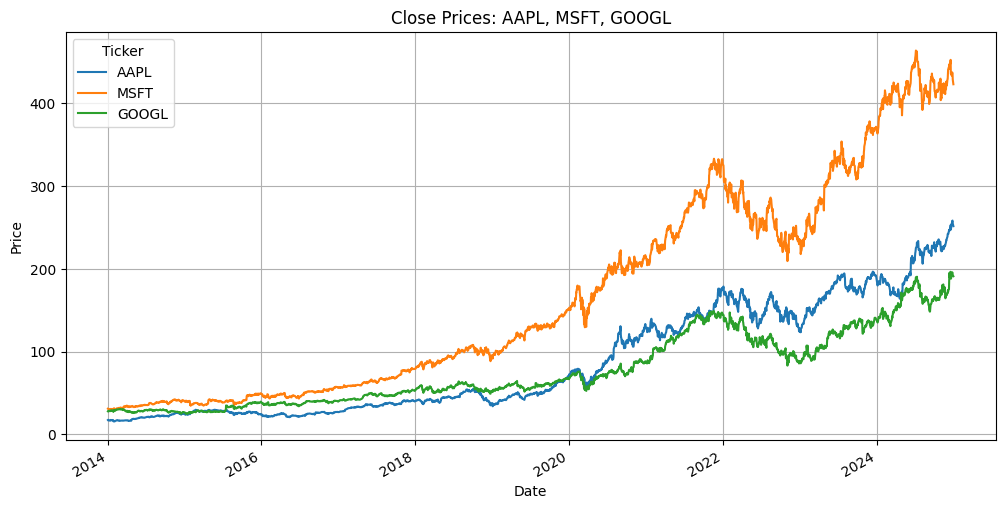

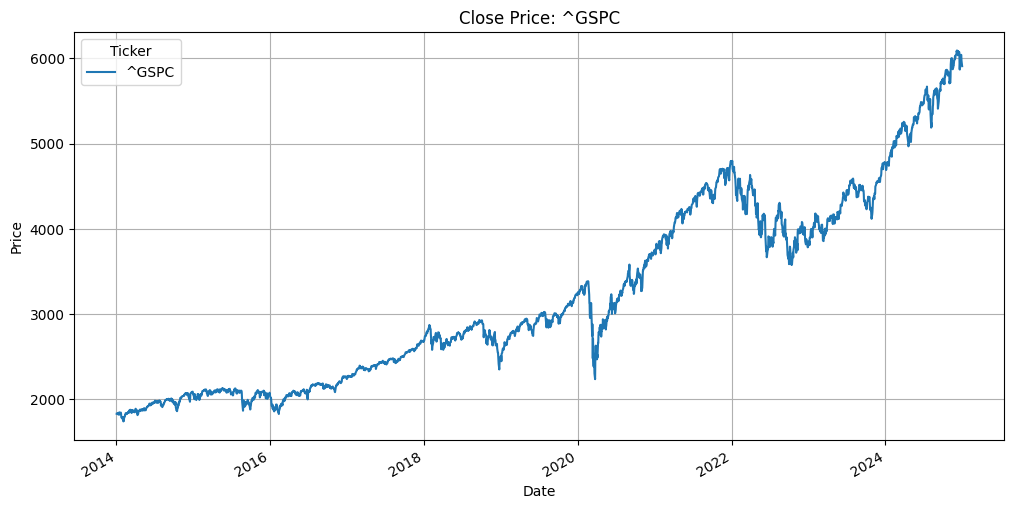

In [8]:
# Plot individual tickers and index ticker (AAPL, MSFT, GOOGL, ^GSPC) in 4 separate windows or in a single window
'''
if not close_data.empty:
    print("\n--- Plotting Close Prices ---")
    close_data.plot(figsize=(12, 6), title="Close Prices", subplots=False) # subplots=True for separate subplots
    plt.ylabel("Price")
    plt.legend(title='Ticker')
    plt.show()
'''

# Plot individual tickers (AAPL, MSFT, GOOGL) and index ticker (^GSPC) in 2 separate windows
if not close_data.empty:
    print("\n--- Plotting Close Prices ---")

    individual_tickers = tickers_list[:3] # AAPL, MSFT, GOOGL
    index_ticker = tickers_list[3]  # ^GSPC - S&P 500

    # --- AAPL, MSFT, GOOGL ---
    if all(ticker in close_data.columns for ticker in individual_tickers):
        fig1, ax1 = plt.subplots(figsize=(12, 6))

        for ticker in individual_tickers:
            close_data[ticker].plot(ax=ax1, label=ticker)

        ax1.set_title(f"Close Prices: {', '.join(individual_tickers)}")
        ax1.set_ylabel("Price")
        ax1.legend(title='Ticker')
        ax1.grid(True)

    else:
        print(f"Warning: Not all individual tickers ({', '.join(individual_tickers)}) found in close_data.")

    # --- ^GSPC ---
    if index_ticker in close_data.columns:
        fig2, ax2 = plt.subplots(figsize=(12, 6))

        close_data[index_ticker].plot(ax=ax2, label=index_ticker)

        ax2.set_title(f"Close Price: {index_ticker}")
        ax2.set_ylabel("Price")
        ax2.legend(title='Ticker')
        ax2.grid(True)

    else:
        print(f"Warning: Index ticker ({index_ticker}) not found in close_data.")
    
    plt.show()

else:
    print("'close_data' is empty. Skipping plotting.")


--- Plotting Close Prices with Moving Averages ---


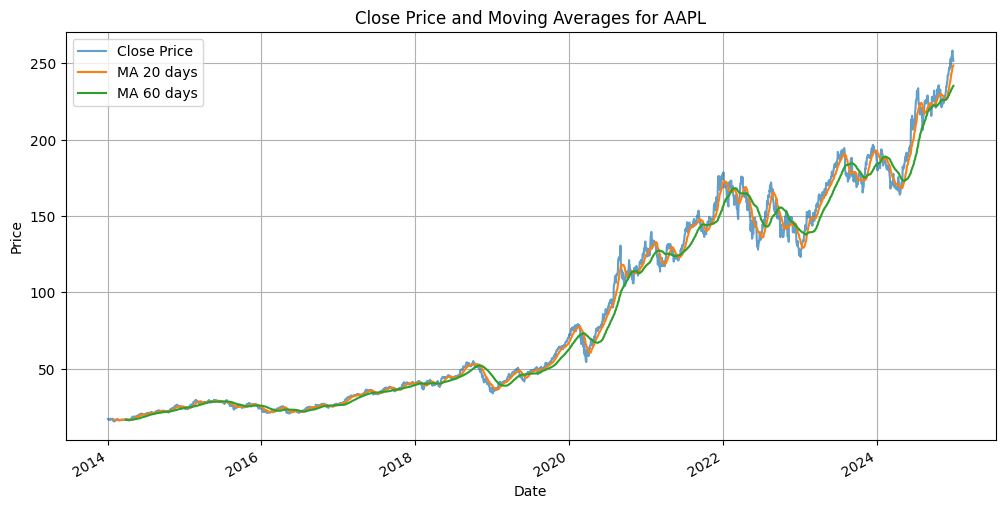

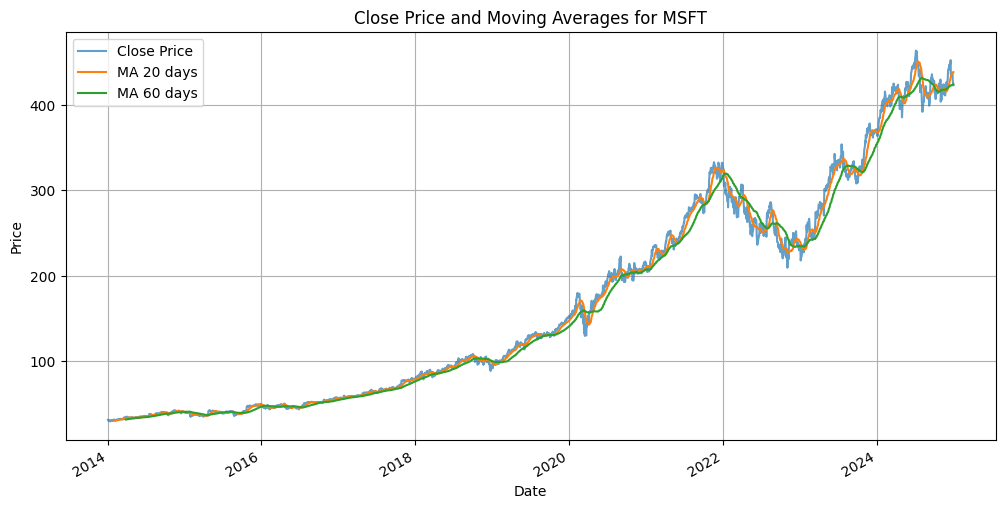

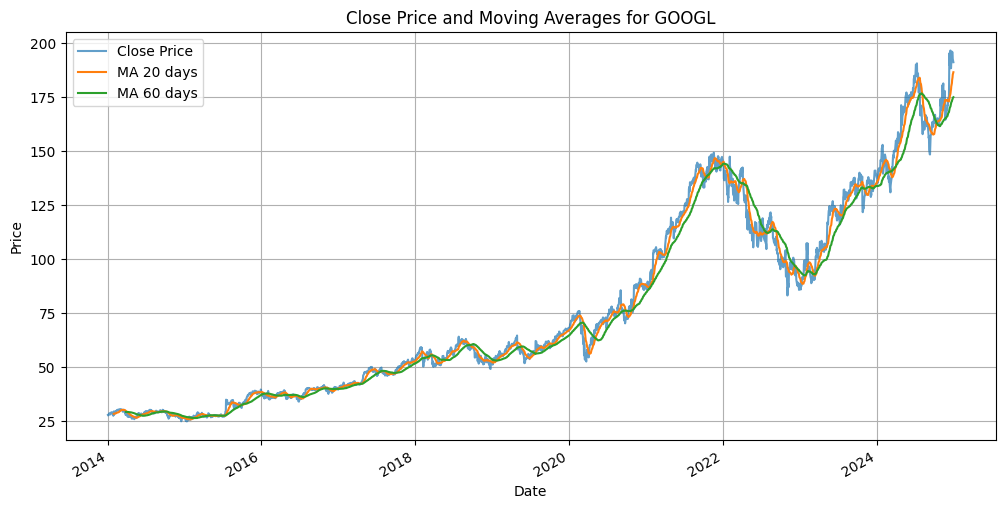

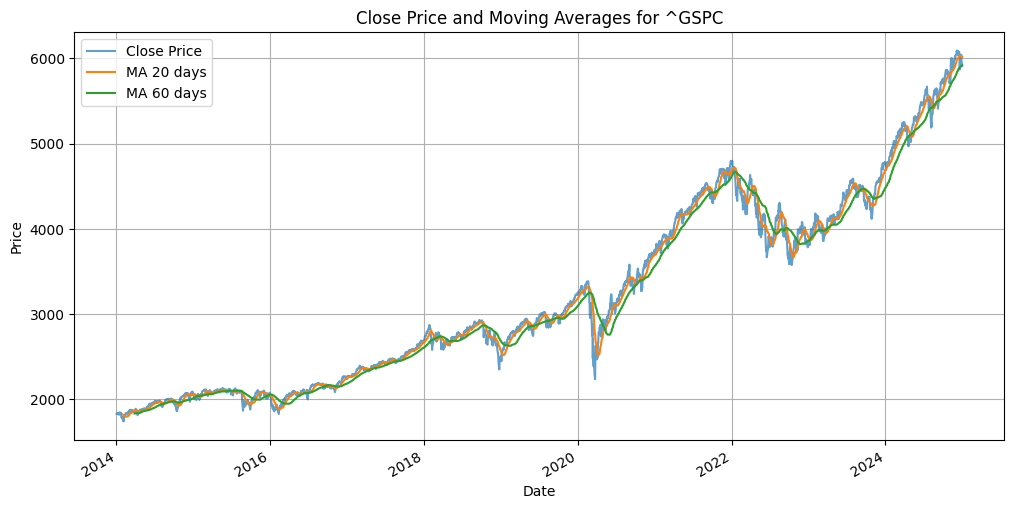

In [9]:
if not close_data.empty:
    print("\n--- Plotting Close Prices with Moving Averages ---")
    short_window = 20  # 20-day moving average (~ month)
    long_window = 60   # 60-day moving average (~ quartal)

    for ticker in tickers_list:
        if ticker in close_data.columns:
            plt.figure(figsize=(12, 6))
            close_data[ticker].plot(label='Close Price', alpha=0.7)
            close_data[ticker].rolling(window=short_window).mean().plot(label=f'MA {short_window} days')
            close_data[ticker].rolling(window=long_window).mean().plot(label=f'MA {long_window} days')
            plt.title(f"Close Price and Moving Averages for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True)
            plt.show()

### 2.2. Statistical Properties of Returns


--- Plotting Daily Returns ---


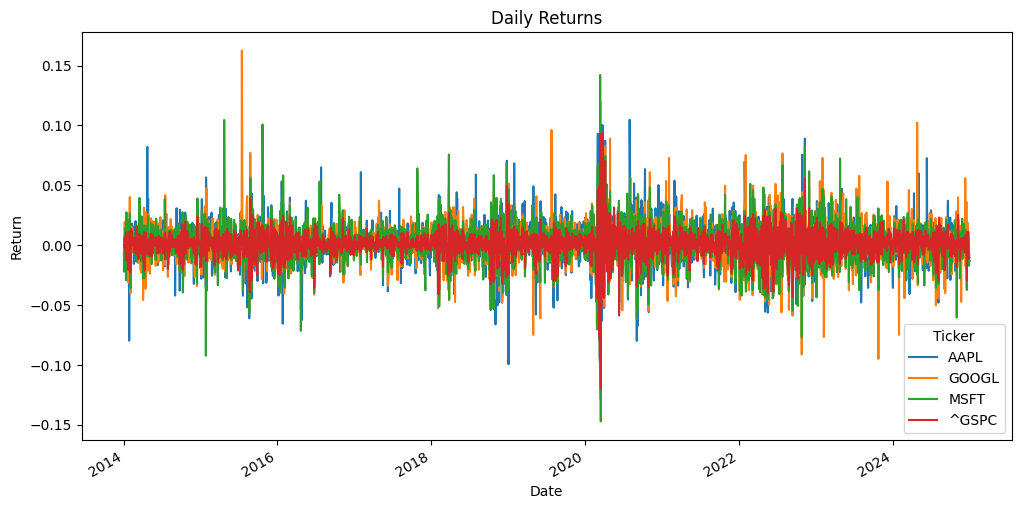

In [10]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Plotting Daily Returns ---")
    daily_returns.plot(figsize=(12, 6), title="Daily Returns", subplots=False) # subplots=True for separate subplots
    plt.ylabel("Return")
    plt.show()


--- Histograms and KDE for Daily Returns ---


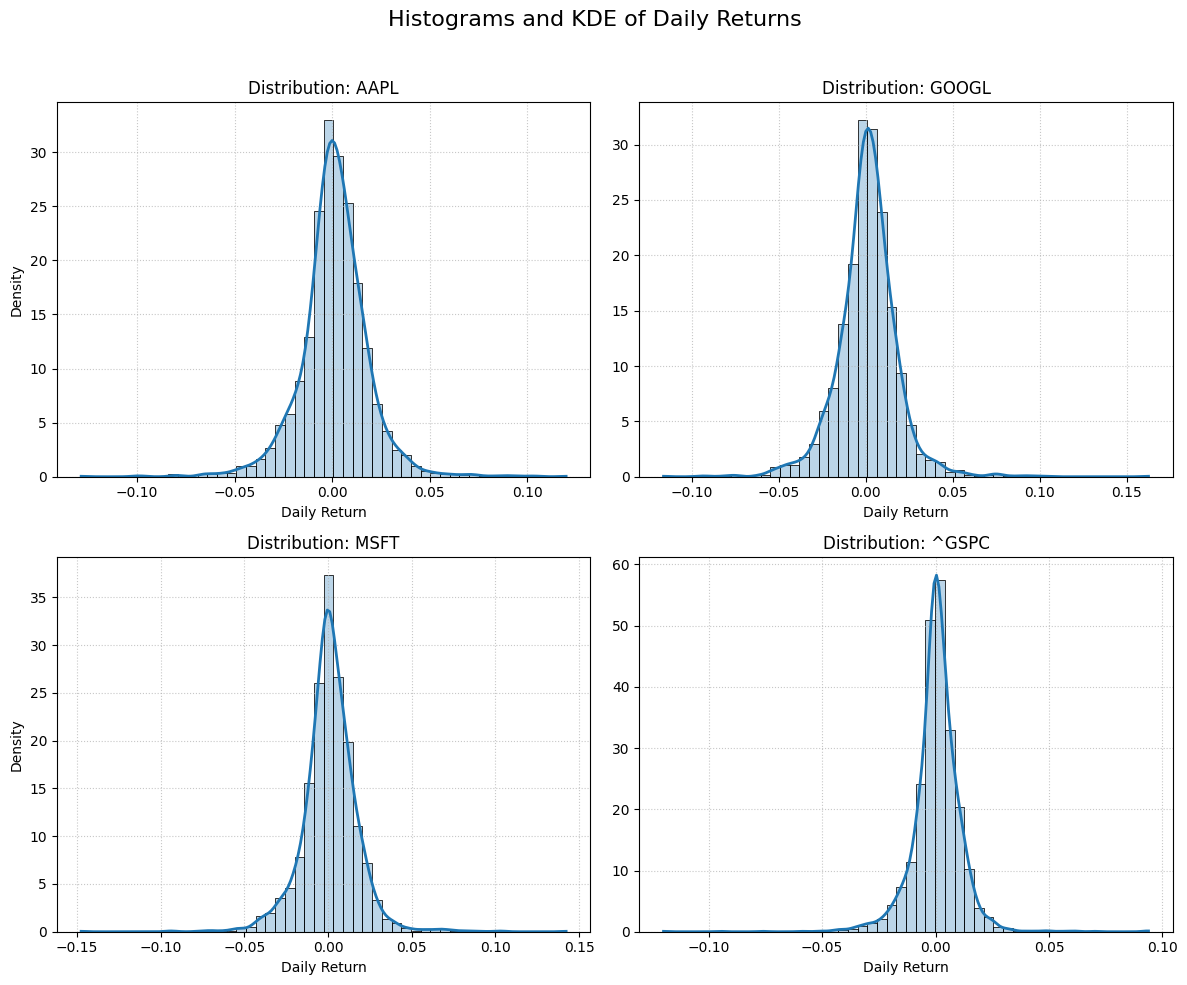

In [11]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Histograms and KDE for Daily Returns ---")

    num_tickers = len(daily_returns.columns)
    if num_tickers <= 0:
        print("No columns in daily_returns to plot.")
    else:
        nrows = 2
        ncols = 2
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10), sharex=False, sharey=False)
        axes_flat = axes.flatten()

        # Choose the type of staticstics for plotting histogram - density or frequency
        stat_type = "density"
        # stat_type = "frequency"

        for i, ticker in enumerate(daily_returns.columns):
            current_ax = axes_flat[i]

            sns.histplot(daily_returns[ticker], kde=True, bins=50, ax=current_ax, stat=stat_type, alpha=0.3, line_kws={'linewidth': 2})

            current_ax.set_title(f"Distribution: {ticker}")
            current_ax.set_xlabel("Daily Return")
                
            # Y-axis labels
            if i % ncols == 0: 
                current_ax.set_ylabel(stat_type.capitalize())
            else:
                current_ax.set_ylabel("")

            current_ax.grid(True, linestyle=':', alpha=0.7)

        
        fig.suptitle("Histograms and KDE of Daily Returns", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping histograms.")

In [33]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Descriptive Statistics for Daily Returns ---")
    desc_stats = daily_returns.describe()
    print(desc_stats)

    print("\nSkewness:")
    print(daily_returns.skew())
    print("\nKurtosis:")
    print(daily_returns.kurt())

    print("\n--- Extreme Daily Returns and Their Dates ---")
    extreme_values_info = []

    # Min and max returns and their dates
    for ticker in daily_returns.columns:
        min_return = daily_returns[ticker].min()
        date_min_return = daily_returns[ticker].idxmin()

        max_return = daily_returns[ticker].max()
        date_max_return = daily_returns[ticker].idxmax()

        extreme_values_info.append({
            "Ticker": ticker,
            "Min Return": min_return,
            "Date of Min Return": date_min_return.strftime('%Y-%m-%d'),
            "Max Return": max_return,
            "Date of Max Return": date_max_return.strftime('%Y-%m-%d')
        })

    extreme_values_df = pd.DataFrame(extreme_values_info)
    extreme_values_df = extreme_values_df.set_index("Ticker")

    print(extreme_values_df)

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping descriptive statistics.")


--- Descriptive Statistics for Daily Returns ---
Ticker         AAPL        GOOGL         MSFT        ^GSPC
count   2766.000000  2766.000000  2766.000000  2766.000000
mean       0.001125     0.000852     0.001085     0.000483
std        0.017582     0.017573     0.016695     0.010922
min       -0.128647    -0.116341    -0.147390    -0.119841
25%       -0.007012    -0.007571    -0.006717    -0.003737
50%        0.001001     0.001142     0.000908     0.000653
75%        0.010116     0.009470     0.009664     0.005662
max        0.119808     0.162584     0.142169     0.093828

Skewness:
Ticker
AAPL    -0.011635
GOOGL    0.230104
MSFT     0.075650
^GSPC   -0.532558
dtype: float64

Kurtosis:
Ticker
AAPL      5.567478
GOOGL     6.688485
MSFT      7.904332
^GSPC    14.952258
dtype: float64

--- Extreme Daily Returns and Their Dates ---
        Min Return Date of Min Return  Max Return Date of Max Return
Ticker                                                              
AAPL     -0.128647  

Large kurtosis values (> 5) demonstrate the daily returns distributions are non-Gaussian and have havier tails. NORMALITY ANALYSIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


--- Boxplots for Daily Returns ---


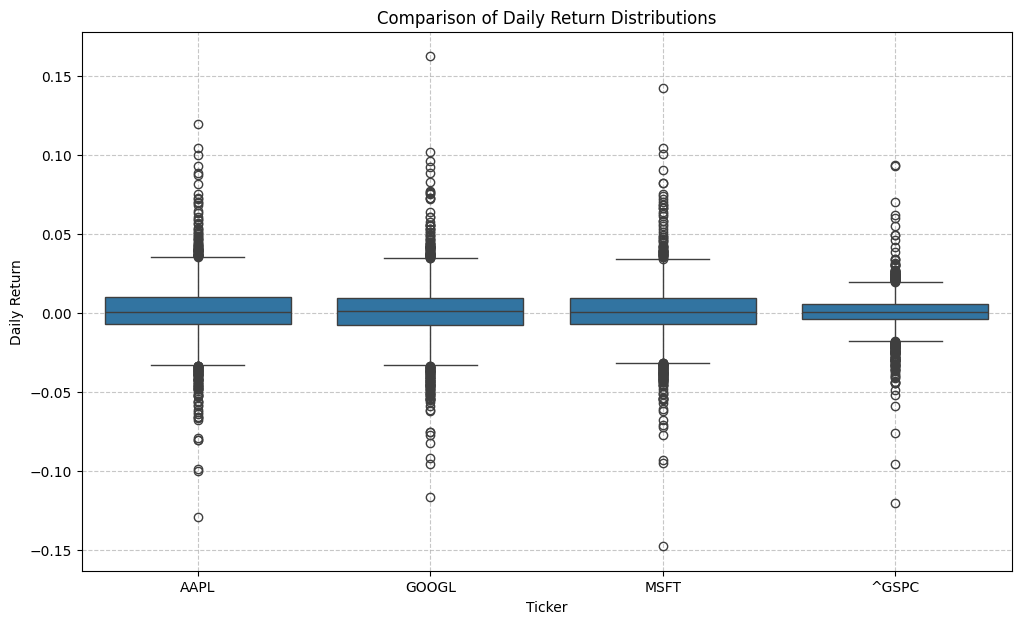

In [34]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Boxplots for Daily Returns ---")
    melted_returns = daily_returns.melt(var_name='Ticker', value_name='Return')

    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Ticker', y='Return', data=melted_returns)
    plt.title("Comparison of Daily Return Distributions")
    plt.xlabel("Ticker")
    plt.ylabel("Daily Return")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### 2.3. Volatility analysis


--- Plotting and Analyzing Rolling Volatility ---


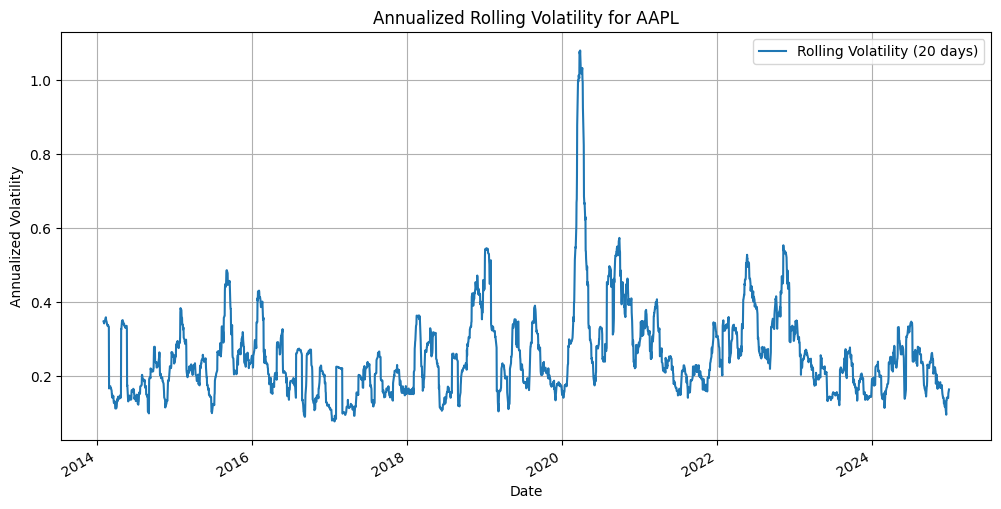

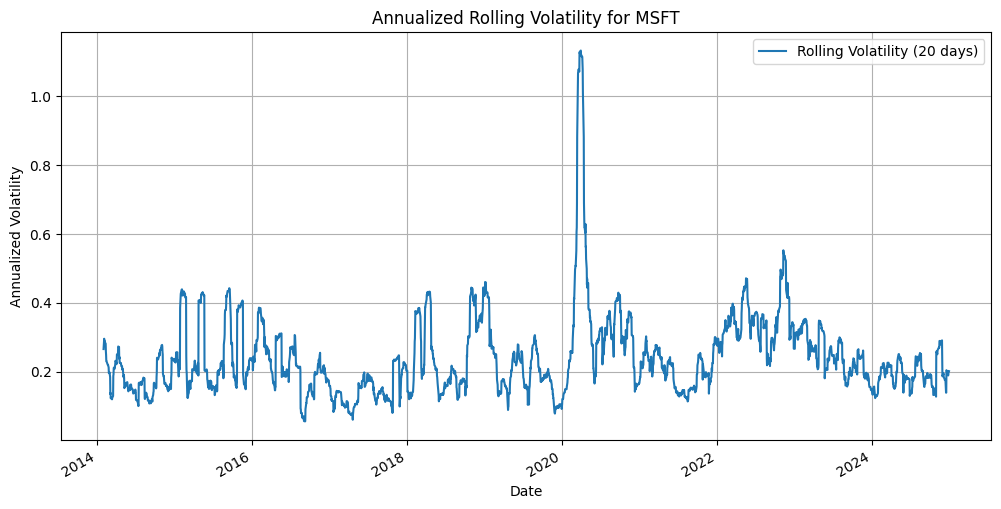

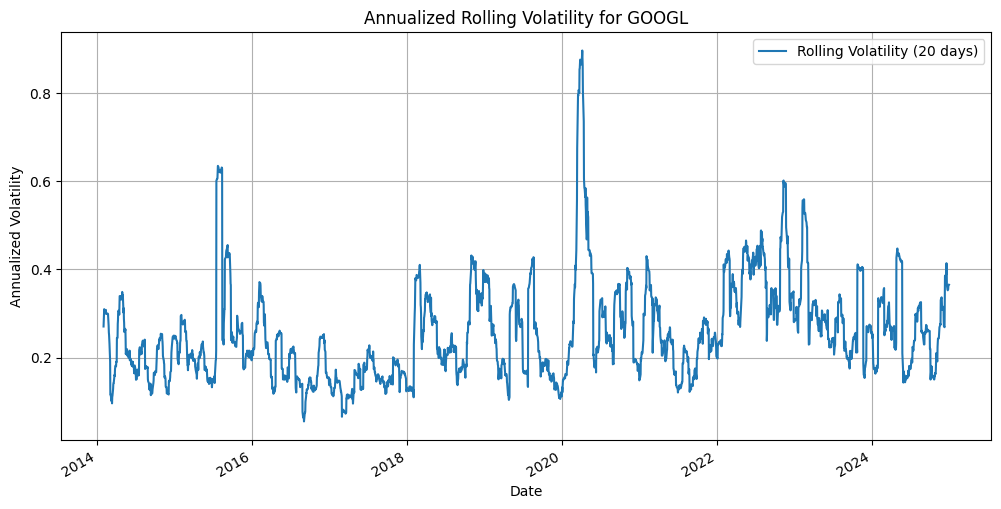

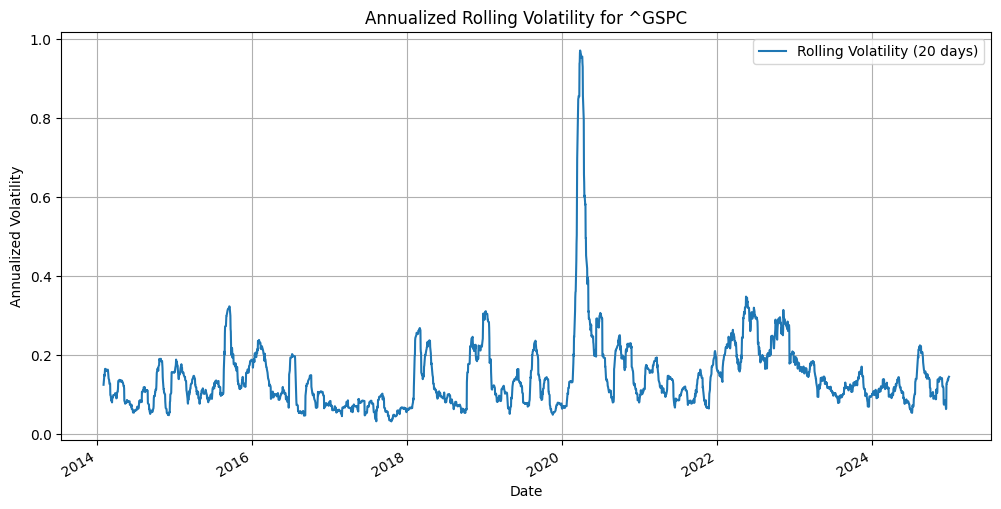


--- Peak Annualized Rolling Volatility ---
        Max Volatility Date of Max Volatility
Ticker                                       
AAPL          1.079532             2020-03-27
MSFT          1.131446             2020-03-30
GOOGL         0.895755             2020-04-06
^GSPC         0.971241             2020-03-27


In [47]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Plotting and Analyzing Rolling Volatility ---")
    vol_window = 20

    max_rolling_volatility_info = []

    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            rolling_std = daily_returns[ticker].rolling(window=vol_window).std() * (252**0.5) # Annualized volatility

            if not rolling_std.dropna().empty:
                max_vol = rolling_std.dropna().max()
                date_max_vol = rolling_std.dropna().idxmax()
                
                max_rolling_volatility_info.append({
                    "Ticker": ticker,
                    "Max Volatility": max_vol,
                    "Date of Max Volatility": date_max_vol.strftime('%Y-%m-%d')
                })
            else:
                max_rolling_volatility_info.append({
                    "Ticker": ticker,
                    "Max Volatility": np.nan,
                    "Date of Max Volatility": "N/A"
                })

            plt.figure(figsize=(12, 6))
            rolling_std.plot(label=f'Rolling Volatility ({vol_window} days)')
            plt.title(f"Annualized Rolling Volatility for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Annualized Volatility")
            plt.legend()
            plt.grid(True)
            plt.show()

    if max_rolling_volatility_info:
        max_rolling_vol_df = pd.DataFrame(max_rolling_volatility_info)
        max_rolling_vol_df = max_rolling_vol_df.set_index("Ticker")
        print("\n--- Peak Annualized Rolling Volatility ---")
        print(max_rolling_vol_df)

else:
    print("DataFrame 'daily_returns' is empty or not defined. Skipping rolling volatility analysis.")


--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---


<Figure size 1200x600 with 0 Axes>

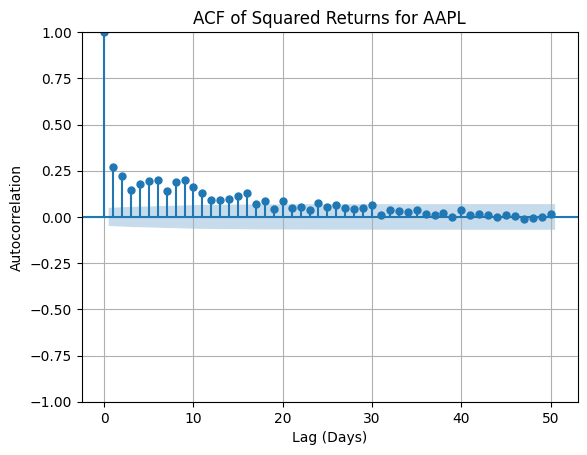

<Figure size 1200x600 with 0 Axes>

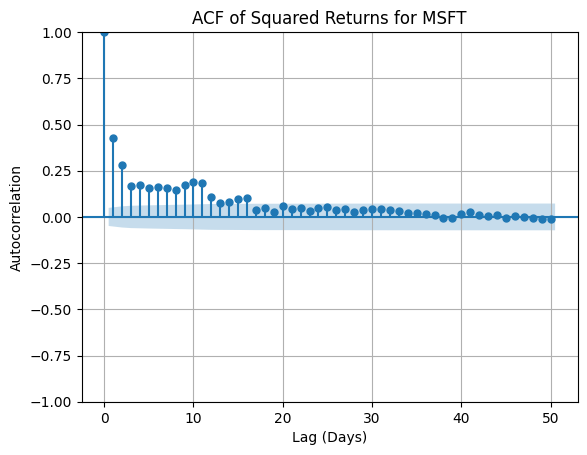

<Figure size 1200x600 with 0 Axes>

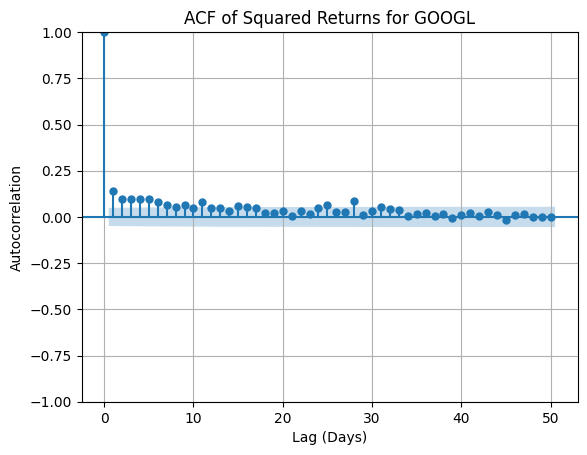

<Figure size 1200x600 with 0 Axes>

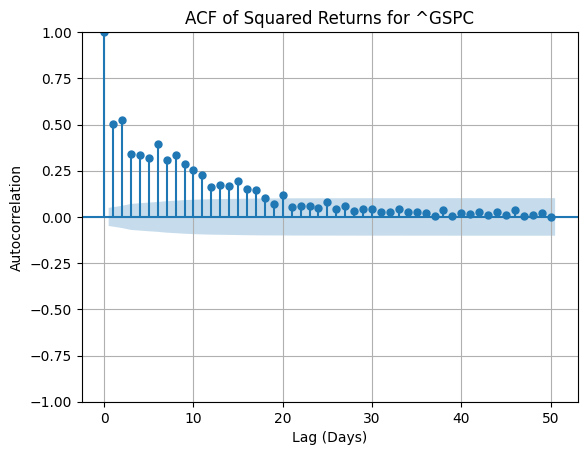

In [52]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---")
    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            squared_returns = daily_returns[ticker]**2
            plt.figure(figsize=(12, 6))
            plot_acf(squared_returns, lags=50, alpha = 0.01, title=f'ACF of Squared Returns for {ticker}') # try different alphas
            plt.xlabel("Lag (Days)")
            plt.ylabel("Autocorrelation")
            plt.grid(True)
            plt.show()

Conclusion on volatility analysis. AUTOCORRELATION ANALYSIS

# 3. Cross-Asset Analysis and Correlations

### 3.1. Risk-Return Profile Comparison


--- Risk-Return Profile Analysis ---

Risk-Return Profile (Annualized):
        Annualized Return  Annualized Volatility
Ticker                                          
AAPL             0.283531               0.279101
GOOGL            0.214716               0.278957
MSFT             0.273520               0.265028
^GSPC            0.121776               0.173382


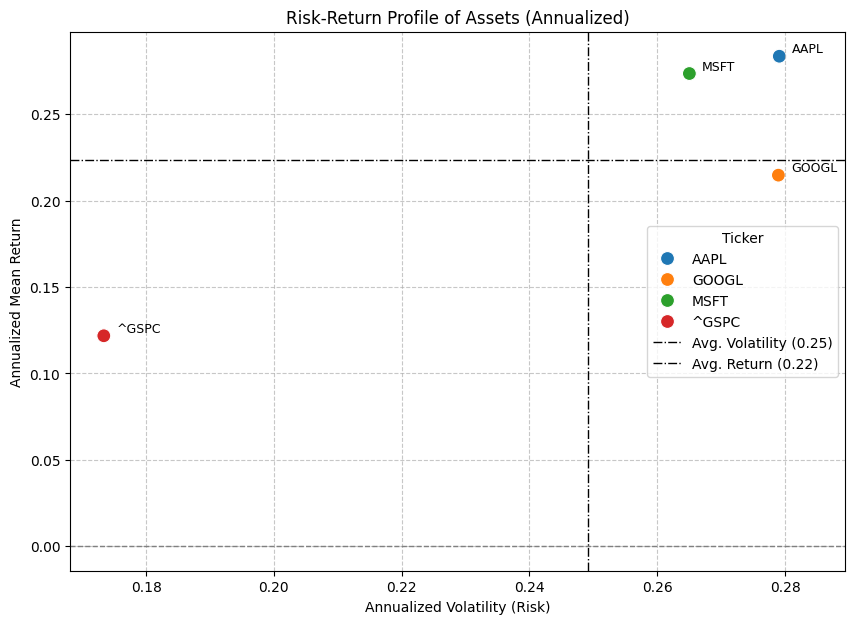

In [71]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Risk-Return Profile Analysis ---")

    mean_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()

    # Annualized return and volatility
    annualized_returns = mean_daily_returns * 252
    annualized_volatility = std_daily_returns * np.sqrt(252)

    risk_return_profile = pd.DataFrame({
        'Annualized Return': annualized_returns,
        'Annualized Volatility': annualized_volatility
    })

    print("\nRisk-Return Profile (Annualized):")
    print(risk_return_profile)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Annualized Volatility', y='Annualized Return', data=risk_return_profile, s=100, hue=risk_return_profile.index, legend='full') # s=100 размер точек

    # Points labels
    for i in range(risk_return_profile.shape[0]):
        ticker_name = risk_return_profile.index[i]
        volatility_value = risk_return_profile['Annualized Volatility'].iloc[i]
        return_value = risk_return_profile['Annualized Return'].iloc[i]
        
        plt.text(x=volatility_value+0.002,
                 y=return_value +0.002,
                 s=ticker_name,
                 fontdict=dict(color='black',size=9))

    # Shift right limit of the plot for the labels to not cross the right boundary
    current_xlim = plt.xlim()
    plt.xlim(current_xlim[0], current_xlim[1] + 0.005)
    
    plt.title('Risk-Return Profile of Assets (Annualized)')
    plt.xlabel('Annualized Volatility (Risk)')
    plt.ylabel('Annualized Mean Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', linestyle='--', lw=1) # Zero
    
    avg_vol = annualized_volatility.mean()
    avg_ret = annualized_returns.mean()
    plt.axvline(avg_vol, color='black', linestyle='-.', lw=1, label=f'Avg. Volatility ({avg_vol:.2f})')
    plt.axhline(avg_ret, color='black', linestyle='-.', lw=1, label=f'Avg. Return ({avg_ret:.2f})')
    
    plt.legend(title='Ticker')
    plt.show()

### 3.2. Correlation Analysis


--- Correlation Matrix of Daily Returns ---
Ticker      AAPL     GOOGL      MSFT     ^GSPC
Ticker                                        
AAPL    1.000000  0.583078  0.660009  0.732150
GOOGL   0.583078  1.000000  0.699928  0.716918
MSFT    0.660009  0.699928  1.000000  0.788413
^GSPC   0.732150  0.716918  0.788413  1.000000


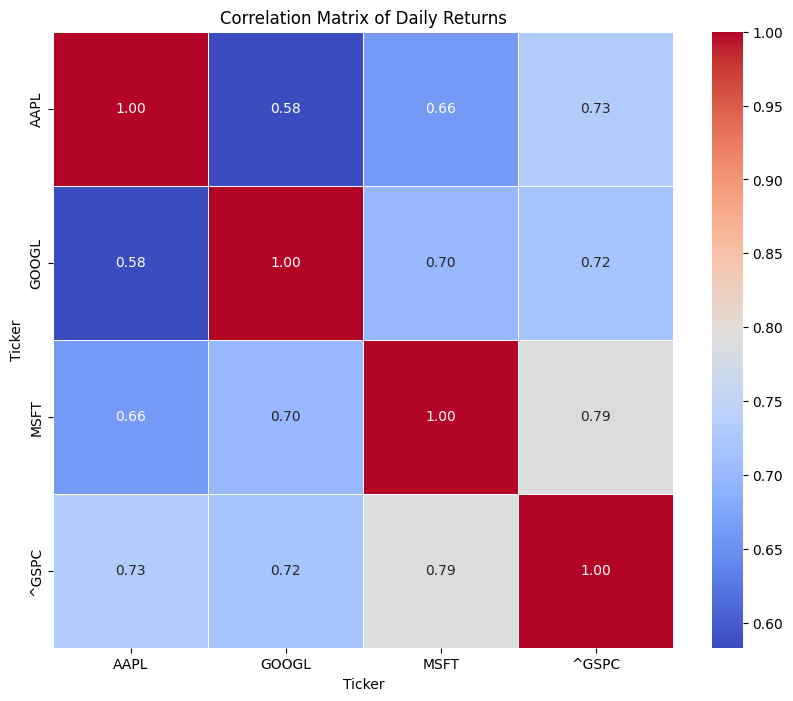

In [82]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Correlation Matrix of Daily Returns ---")
    correlation_matrix = daily_returns.corr()
    print(correlation_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix of Daily Returns")
    plt.show()

### 3.3. Beta Analysis


--- Scatter Plots of Returns (vs S&P 500) ---


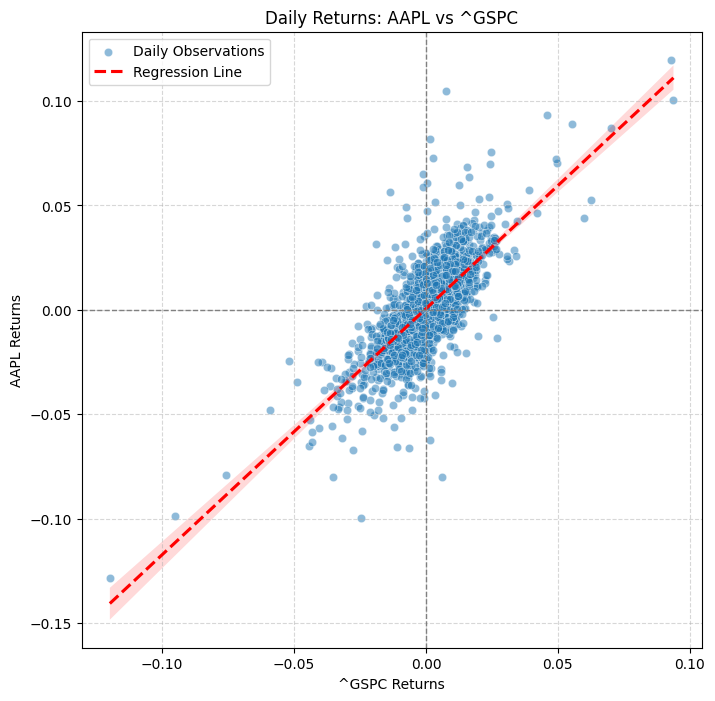

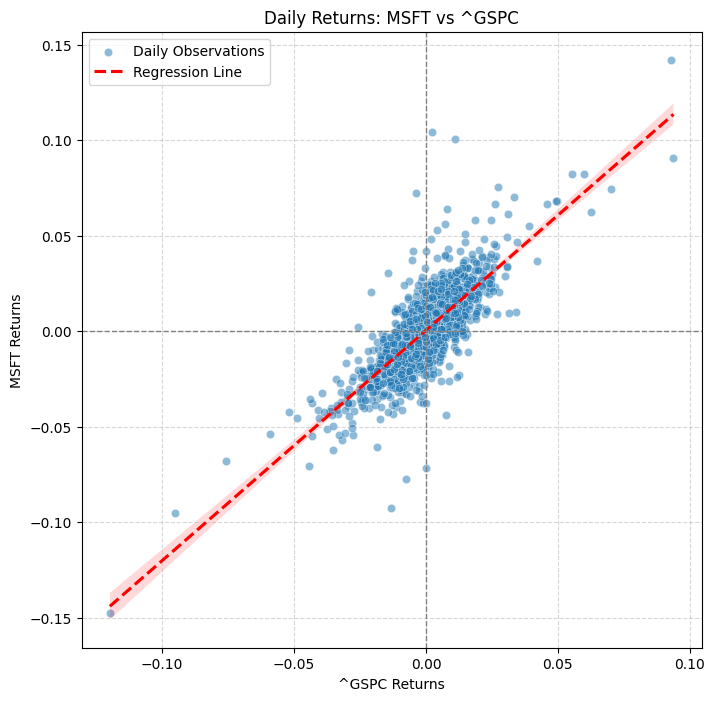

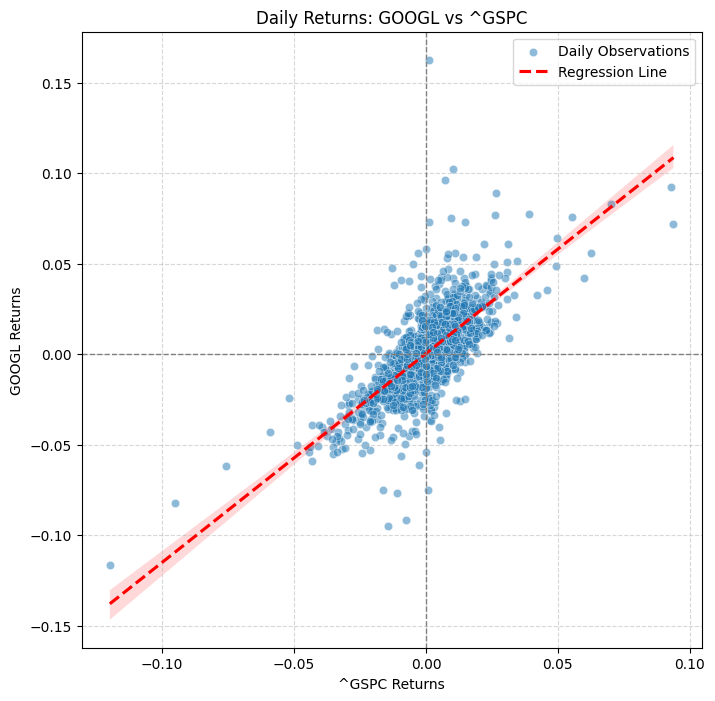

In [81]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    print("\n--- Scatter Plots of Returns (vs S&P 500) ---")
    market_ticker = '^GSPC'
    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            plt.figure(figsize=(8, 8))

            sns.scatterplot(
                x=daily_returns[market_ticker], 
                y=daily_returns[ticker], 
                alpha=0.5, 
                label='Daily Observations'
            ) 
            # Regression line
            sns.regplot(
                x=daily_returns[market_ticker], 
                y=daily_returns[ticker], 
                scatter=False,
                ci = 99, # 99%-confidence interval
                color='red',
                line_kws={'linestyle':'--'},
                label='Regression Line'
            )
            plt.title(f"Daily Returns: {ticker} vs {market_ticker}")
            plt.xlabel(f"{market_ticker} Returns")
            plt.ylabel(f"{ticker} Returns")
            plt.axhline(0, color='grey', linestyle='--', lw=1) # Zero line
            plt.axvline(0, color='grey', linestyle='--', lw=1) # Zero line
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()


--- Beta Coefficient Calculation ---
           Beta  Annualized Alpha  R-squared
AAPL   1.178578          0.140009   0.536044
MSFT   1.205153          0.126762   0.621596
GOOGL  1.153464          0.074252   0.513971


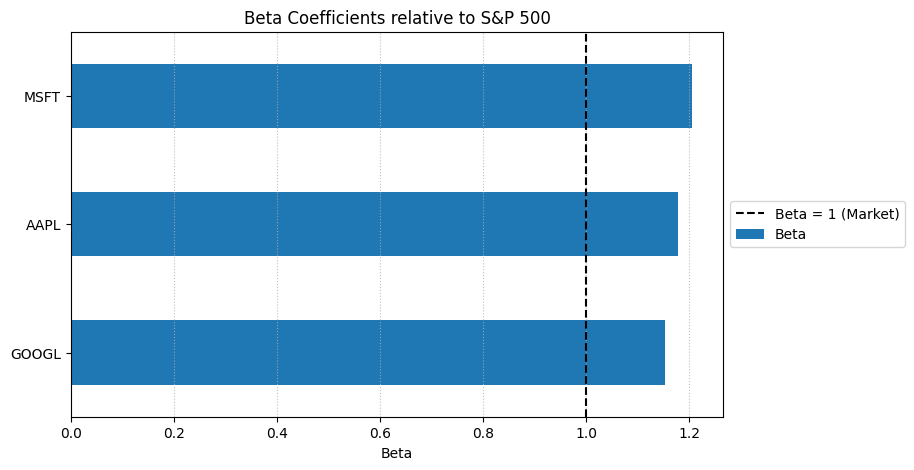

In [94]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    print("\n--- Beta Coefficient Calculation ---")
    market_ticker = '^GSPC'
    market_returns = daily_returns[market_ticker].dropna()

    beta_values = {}
    alpha_values = {}
    r_squared_values = {}

    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            asset_returns = daily_returns[ticker].dropna()

            # Make sure date indices are the same
            common_index = market_returns.index.intersection(asset_returns.index)
            X = market_returns.loc[common_index]
            y = asset_returns.loc[common_index]

            if len(X) > 1 and len(y) > 1:
                slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
                beta_values[ticker] = slope
                alpha_values[ticker] = intercept * 252 # Annualized alpha
                r_squared_values[ticker] = r_value**2
            else:
                print(f"Not enough data points for regression for {ticker} after aligning with market.")
                beta_values[ticker] = np.nan
                alpha_values[ticker] = np.nan
                r_squared_values[ticker] = np.nan


    beta_df = pd.DataFrame.from_dict(beta_values, orient='index', columns=['Beta'])
    alpha_df = pd.DataFrame.from_dict(alpha_values, orient='index', columns=['Annualized Alpha'])
    r_squared_df = pd.DataFrame.from_dict(r_squared_values, orient='index', columns=['R-squared'])

    beta_analysis_df = pd.concat([beta_df, alpha_df, r_squared_df], axis=1)
    
    print(beta_analysis_df)

    if not beta_analysis_df.empty:
        beta_to_plot = beta_analysis_df['Beta'].sort_values(ascending=True)

        fig, ax = plt.subplots(figsize=(9, 5))
        
        beta_to_plot.plot(kind='barh', color='tab:blue', label='Beta', ax=ax)
        
        ax.set_title('Beta Coefficients relative to S&P 500')
        ax.set_xlabel('Beta')
        # ax.set_ylabel('Ticker')
        
        ax.axvline(1.0, color='black', linestyle='--', label='Beta = 1 (Market)')
        
        fig.subplots_adjust(right=0.85)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        ax.grid(axis='x', linestyle=':', alpha=0.8)
        plt.show()

Conclusion.
Бета показывает, как доходность акции реагирует на изменение доходности рынка.
Бета = 1: Акция движется вровень с рынком.
Бета > 1: Акция более волатильна, чем рынок (усиливает движения рынка).
Бета < 1: Акция менее волатильна, чем рынок.
Бета = 0: Движение акции не зависит от рынка.
Бета < 0: Акция движется в противофазе с рынком (редко для отдельных акций).

    Бета: Как описано выше.

    Альфа (аннуализированная): Показывает, насколько в среднем акция превзошла (положительная альфа) или уступила (отрицательная альфа) рынку, учитывая ее уровень систематического риска (Бету). Положительная альфа часто ищется инвесторами.

    R-квадрат (R-squared): Показывает, какая доля вариации доходности акции объясняется вариацией доходности рынка. Значение от 0 до 1. Чем ближе к 1, тем сильнее связь акции с рынком (и тем надежнее оценка Беты).

## 4. COVID-19 crisis

### 4.1. Data preparation

In [20]:
# Определим даты для анализа периода COVID-19
covid_start_date = "2019-12-01"
covid_end_date = "2020-06-30"

# Отфильтруем наши основные DataFrame (close_data и daily_returns) для этого периода
if not close_data.empty:
    close_data_covid = close_data.loc[covid_start_date:covid_end_date].copy()
else:
    close_data_covid = pd.DataFrame()

if 'daily_returns' in locals() and not daily_returns.empty:
    daily_returns_covid = daily_returns.loc[covid_start_date:covid_end_date].copy()
else:
    daily_returns_covid = pd.DataFrame()

print(f"\n--- Analyzing COVID-19 Impact Period: {covid_start_date} to {covid_end_date} ---")

if close_data_covid.empty or daily_returns_covid.empty:
    print("Not enough data for the specified COVID-19 period. Skipping this section.")


--- Analyzing COVID-19 Impact Period: 2019-12-01 to 2020-06-30 ---


### 4.1. Визуализация: Графики цен и скользящей волатильности (период COVID-19)


--- Price Dynamics during COVID-19 (2019-12-01 to 2020-06-30) ---


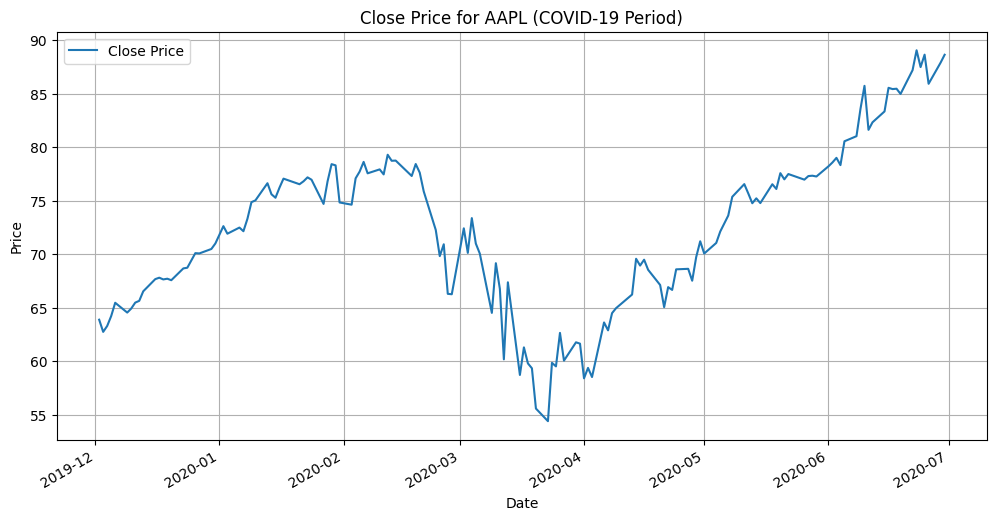

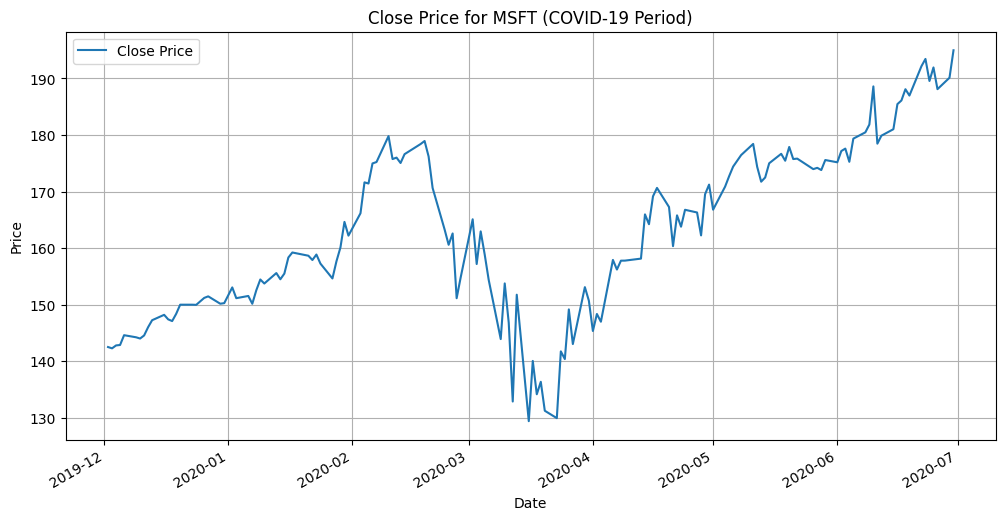

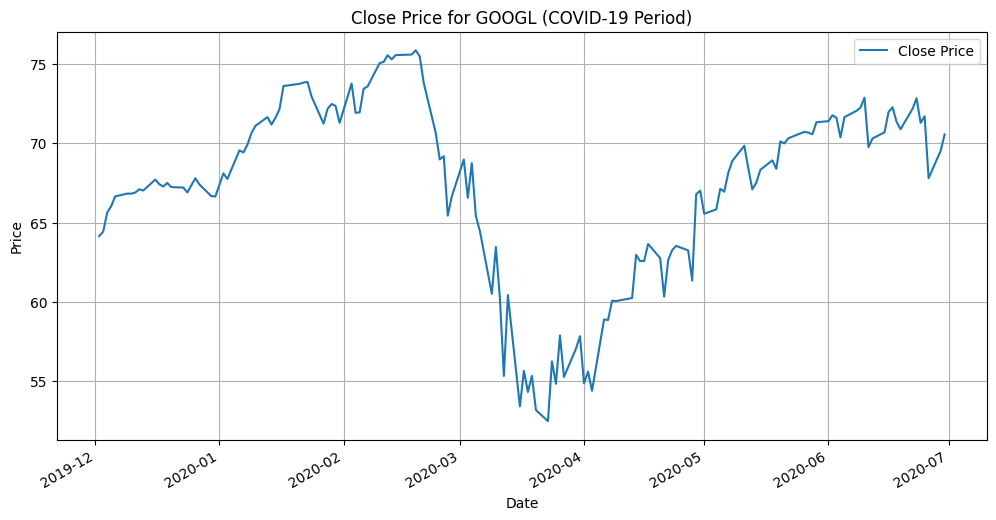

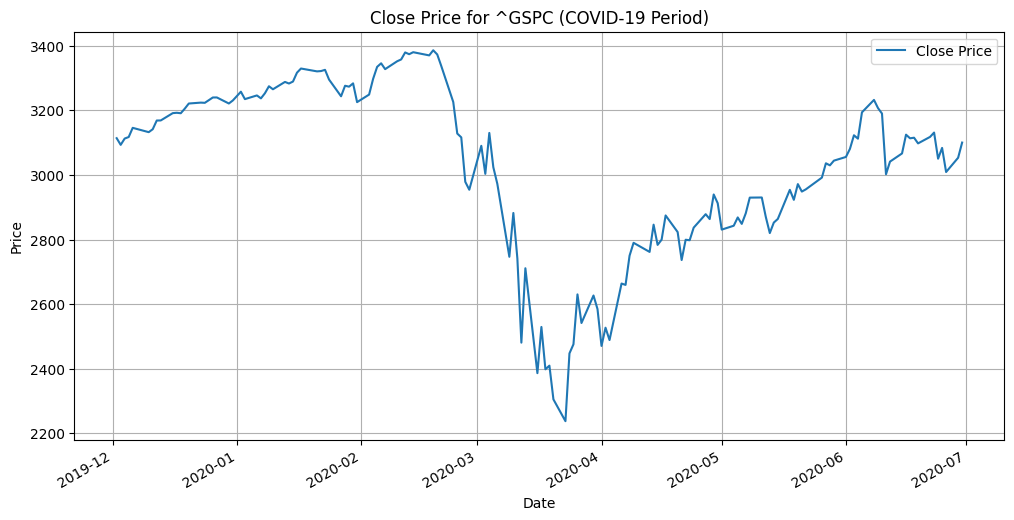


--- Rolling Volatility during COVID-19 (2019-12-01 to 2020-06-30) ---


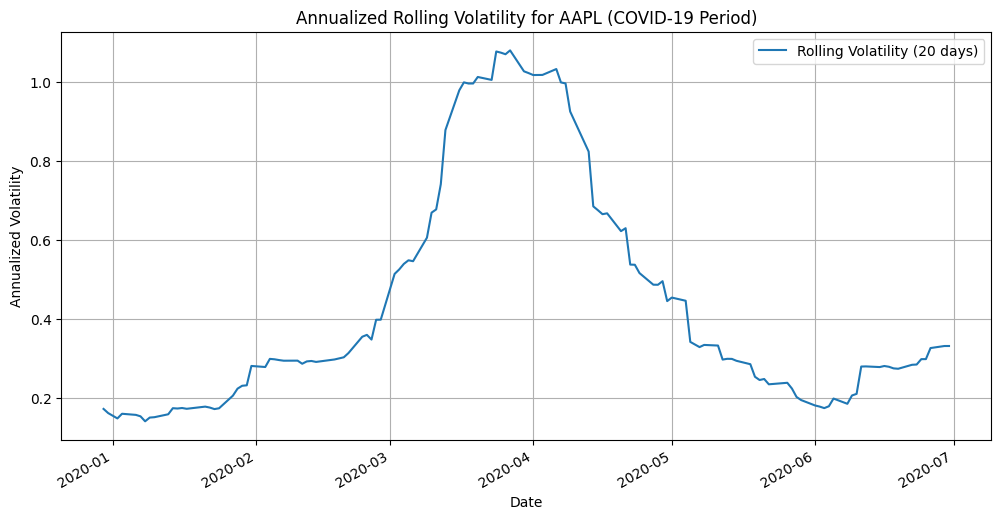

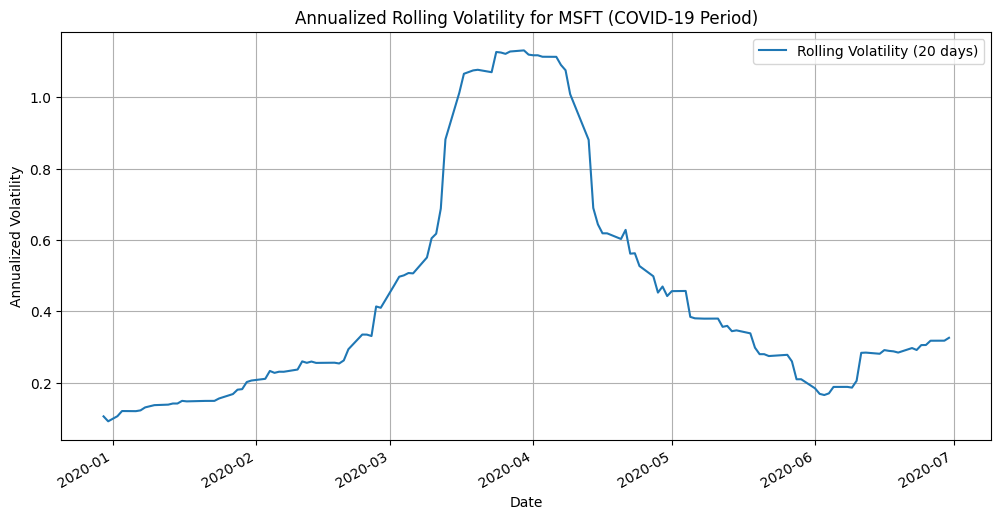

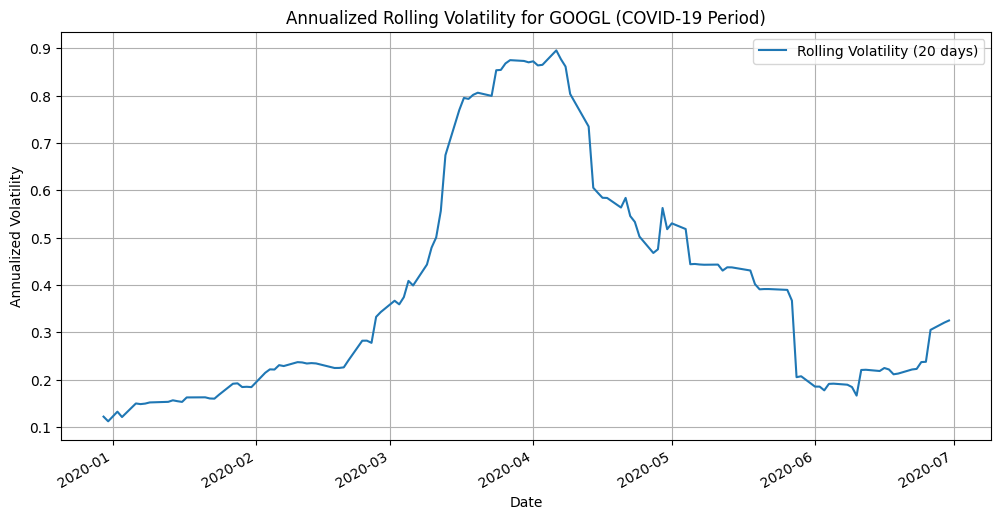

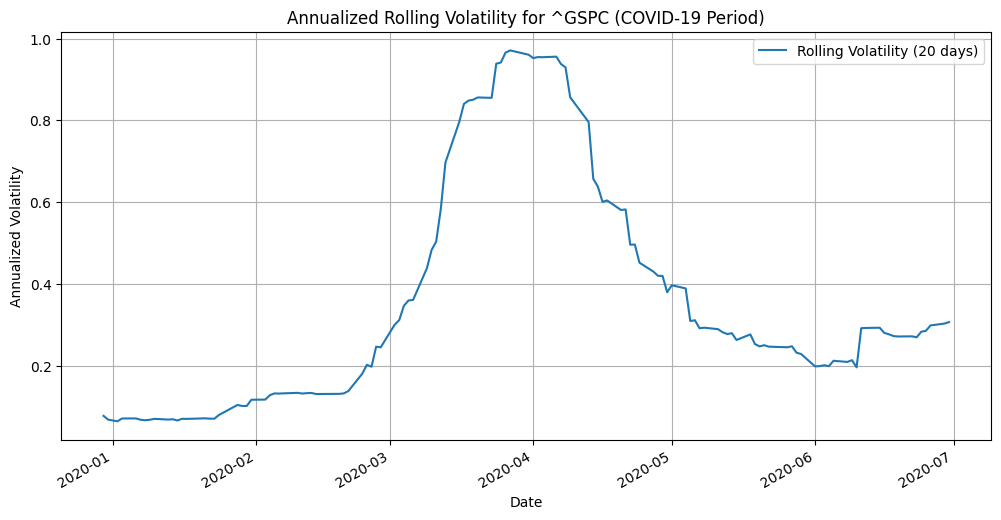

In [21]:
# Вставьте этот код в раздел 4. Глубокий анализ периода рыночного стресса

if not close_data_covid.empty and not daily_returns_covid.empty:
    print(f"\n--- Price Dynamics during COVID-19 ({covid_start_date} to {covid_end_date}) ---")
    for ticker in tickers_list:
        if ticker in close_data_covid.columns:
            plt.figure(figsize=(12, 6))
            close_data_covid[ticker].plot(label='Close Price')
            plt.title(f"Close Price for {ticker} (COVID-19 Period)")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True)
            plt.show()

    print(f"\n--- Rolling Volatility during COVID-19 ({covid_start_date} to {covid_end_date}) ---")
    vol_window = 20 # То же окно, что и раньше, для сопоставимости

    for ticker in tickers_list:
        if ticker in daily_returns_covid.columns:
            # Рассчитываем скользящую волатильность на данных ТОЛЬКО этого периода
            rolling_std_covid = daily_returns_covid[ticker].rolling(window=vol_window).std() * (252**0.5)

            plt.figure(figsize=(12, 6))
            rolling_std_covid.plot(label=f'Rolling Volatility ({vol_window} days)')
            plt.title(f"Annualized Rolling Volatility for {ticker} (COVID-19 Period)")
            plt.xlabel("Date")
            plt.ylabel("Annualized Volatility")
            plt.legend()
            plt.grid(True)
            plt.show()
else:
    if not (not close_data.empty and not ('daily_returns' in locals() and not daily_returns.empty)):
         print("Skipping COVID-19 price and volatility plots due to missing base data for the period.")

### 4.2. Расчет и сравнение максимальных просадок (Drawdowns) (период COVID-19)


--- Maximum Drawdowns during COVID-19 (2019-12-01 to 2020-06-30) ---
Maximum Drawdowns (%):
MSFT     28.039267
GOOGL    30.870826
AAPL     31.427280
^GSPC    33.924960
dtype: float64


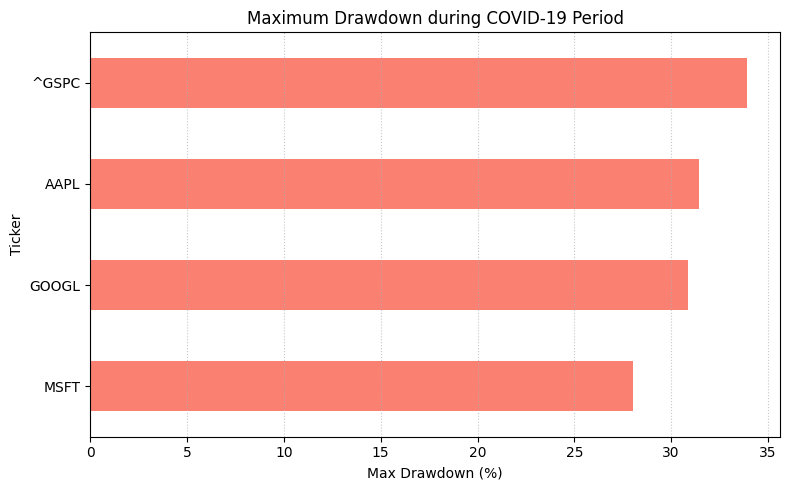

In [22]:
# Вставьте этот код после блока визуализации для периода COVID-19

def calculate_max_drawdown(prices_series):
    """
    Рассчитывает максимальную просадку для временного ряда цен.
    prices_series: pandas Series с ценами.
    """
    if prices_series.empty or len(prices_series) < 2:
        return np.nan

    # 1. Рассчитываем кумулятивный максимум (бегущий пик)
    cumulative_max = prices_series.cummax()
    # 2. Рассчитываем просадку как процентное отклонение от кумулятивного максимума
    # (Пик - Текущая цена) / Пик = 1 - (Текущая цена / Пик)
    drawdown = (cumulative_max - prices_series) / cumulative_max
    # 3. Находим максимальное значение этой просадки
    max_dd = drawdown.max()
    return max_dd

if not close_data_covid.empty:
    print(f"\n--- Maximum Drawdowns during COVID-19 ({covid_start_date} to {covid_end_date}) ---")
    max_drawdowns_covid = {}
    for ticker in tickers_list:
        if ticker in close_data_covid.columns:
            max_drawdowns_covid[ticker] = calculate_max_drawdown(close_data_covid[ticker])
        else:
            max_drawdowns_covid[ticker] = np.nan # Если тикера нет в данных за этот период

    max_drawdowns_df_covid = pd.Series(max_drawdowns_covid).sort_values() # Сортируем для наглядности

    print("Maximum Drawdowns (%):")
    print(max_drawdowns_df_covid * 100) # Выводим в процентах

    # Визуализация максимальных просадок
    if not max_drawdowns_df_covid.dropna().empty: # Проверяем, есть ли не-NaN значения
        plt.figure(figsize=(8, 5))
        (max_drawdowns_df_covid * 100).plot(kind='barh', color='salmon')
        plt.title(f'Maximum Drawdown during COVID-19 Period')
        plt.xlabel('Max Drawdown (%)')
        plt.ylabel('Ticker')
        plt.grid(axis='x', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    if not close_data.empty: # Только если close_data в целом не пуст
        print("Skipping COVID-19 drawdown calculation due to missing price data for the period.")


--- Correlation Matrix of Daily Returns during COVID-19 (2019-12-01 to 2020-06-30) ---


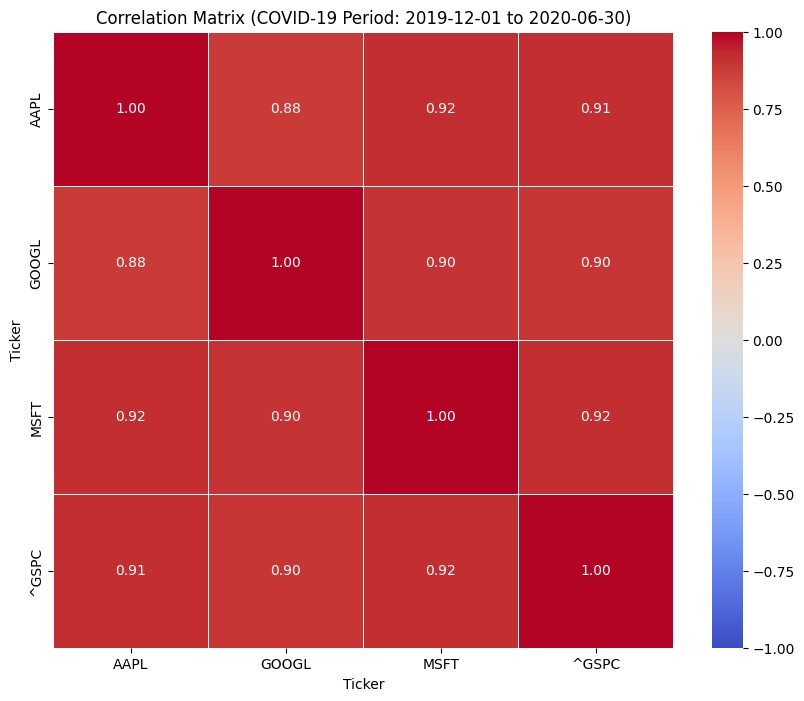


--- Change in Correlations (COVID-19 vs Overall) ---


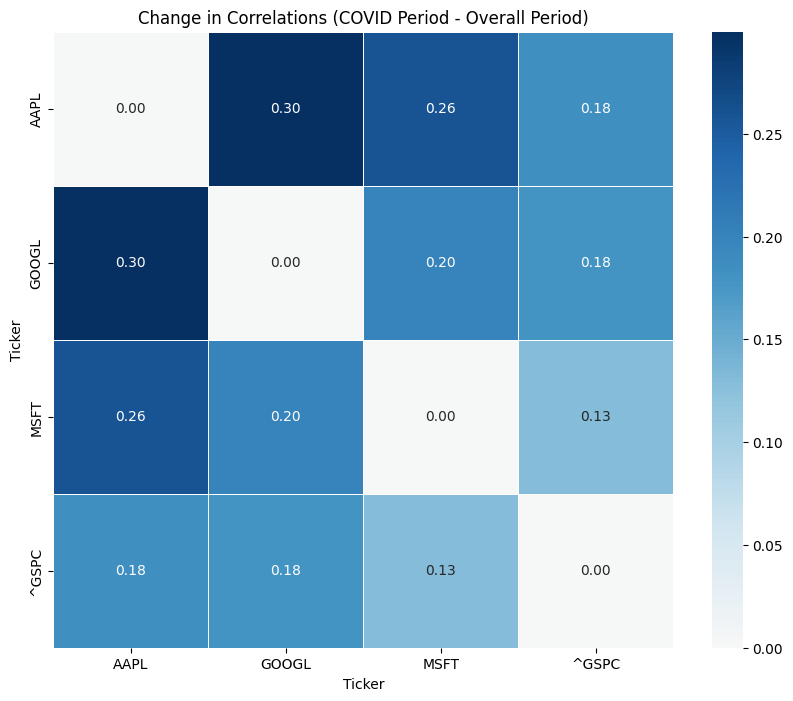

In [23]:
# Вставьте этот код после блока расчета максимальных просадок

if 'daily_returns' in locals() and not daily_returns.empty: # Нужна общая матрица для сравнения
    if not daily_returns_covid.empty:
        print(f"\n--- Correlation Matrix of Daily Returns during COVID-19 ({covid_start_date} to {covid_end_date}) ---")
        correlation_matrix_covid = daily_returns_covid.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix_covid, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
        # vmin и vmax фиксируют шкалу цветов, чтобы можно было сравнивать с другой матрицей
        plt.title(f"Correlation Matrix (COVID-19 Period: {covid_start_date} to {covid_end_date})")
        plt.show()

        # Если у вас есть общая матрица корреляций 'correlation_matrix' из раздела 3.2
        if 'correlation_matrix' in locals():
            print("\n--- Change in Correlations (COVID-19 vs Overall) ---")
            correlation_change = correlation_matrix_covid - correlation_matrix
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_change, annot=True, cmap='RdBu', fmt=".2f", linewidths=.5, center=0)
            # cmap='RdBu' (Red-Blue) хорошо подходит для отображения изменений, center=0 центрирует шкалу на нуле.
            plt.title(f"Change in Correlations (COVID Period - Overall Period)")
            plt.show()
        else:
            print("Overall correlation matrix ('correlation_matrix') not found for comparison.")
    else:
        if not ('daily_returns' in locals() and not daily_returns.empty): # Только если daily_returns в целом не пуст
            print("Skipping COVID-19 correlation analysis due to missing return data for the period.")

Conclusion on section 4

## Conclusion